
### **✅ 1. 데이터 준비 및 정리**

#### 🛠️ **진행 단계**
**1.1 데이터 불러오기**  
- CSV 파일에 저장된 키포인트 데이터를 **Pandas** 사용해서 가져오기

In [16]:
import pandas as pd

file_path = 'filtered_keypoints.csv'
df = pd.read_csv(file_path)

display(df)

,file_name,dancer_height,keypoint_name,x,y
0,MC01_A02_B031_CA1_M0005_2925.json,171,head,2289.192722,968.666352
1,MC01_A02_B031_CA1_M0005_2925.json,171,neck,2185.559677,942.747408
2,MC01_A02_B031_CA1_M0005_2925.json,171,left_wrist,NaN,NaN
3,MC01_A02_B031_CA1_M0005_2925.json,171,right_wrist,2218.533828,1303.256362
4,MC01_A02_B031_CA1_M0005_2925.json,171,left_shoulder,NaN,NaN
...,...,...,...,...,...
280763,MC01_A02_B021_CA1_M0001_300.json,176,right_wrist,1790.119053,1119.451274
280764,MC01_A02_B021_CA1_M0001_300.json,176,left_shoulder,2049.292973,858.366584
280765,MC01_A02_B021_CA1_M0001_300.json,176,right_shoulder,1890.899099,880.767030
280766,MC01_A02_B021_CA1_M0001_300.json,176,left_ankle,2131.174552,1441.687371


**1.2 결측치 처리**  
- 키포인트의 `x`와 `y` 값에 결측치(`NaN`)가 있는 경우 아래와 같이 처리
    - **옵션 1**: 결측치 삭제  
    - **옵션 2**: **interpolation(보간법)** 으로 (평균값, 중간값) 대체

In [17]:
'''결측치 비율 먼저 확인 진행'''

import pandas as pd

# CSV 파일 불러오기
file_path = 'filtered_keypoints.csv'
df = pd.read_csv(file_path)

# 결측치 비율 계산
missing_ratio = df.isnull().sum() / len(df) * 100

# 결과 출력
print("결측치 비율:")
print(missing_ratio)

# 결측치 비율을 시각적으로 보기 위해 정렬하여 출력
missing_ratio_sorted = missing_ratio[missing_ratio > 0].sort_values(ascending=False)
print("\n결측치 비율이 있는 컬럼들:")
print(missing_ratio_sorted)

결측치 비율:
file_name         0.000000
dancer_height     0.000000
keypoint_name     0.000000
x                11.197501
y                11.197501
dtype: float64

결측치 비율이 있는 컬럼들:
x    11.197501
y    11.197501
dtype: float64


---

#### 📊 <font color="skyblue">**Analysis 1**</font>

- 옵션2(보간법)을 사용하는 것이 합리적임
- 이유 : 
    - 결측치 비율이 전체의 <font color="orange">**11.2%**</font> 로 상대적으로 높기 때문에 삭제 시 데이터 손실 우려가 있음
    - 좌표 데이터(x, y)는 시계열 데이터나 연속 좌표 값으로 볼 수 있으므로 linear 보간법이 유효하다고 판단함

---

In [ ]:
import pandas as pd

# CSV 파일 불러오기
file_path = 'filtered_keypoints.csv'
df = pd.read_csv(file_path)

# 결측치 확인
print("Before Interpolation:")
print(df.isnull().sum())

#결측치 -> 보간
df_interpolated = df.interpolate(method='linear')  # 선형 보간
df_interpolated = df_interpolated.ffill().bfill()  # 앞뒤 값으로 보간

# 결과 확인
print("\nAfter Interpolation:")
print(df_interpolated.isnull().sum())

# 보간된 데이터 저장
df_interpolated.to_csv('filtered_keypoints_interpolated.csv', index=False)
print("Interpolated data saved to 'filtered_keypoints_interpolated.csv'")

print("\nRemaining NaN values:")
print(df_interpolated.isnull().sum())


In [18]:
df2 = pd.read_csv('filtered_keypoints_interpolated.csv')

df2.head(9)


,file_name,dancer_height,keypoint_name,x,y
0,MC01_A02_B031_CA1_M0005_2925.json,171,head,2289.192722,968.666352
1,MC01_A02_B031_CA1_M0005_2925.json,171,neck,2185.559677,942.747408
2,MC01_A02_B031_CA1_M0005_2925.json,171,left_wrist,2202.046753,1123.001885
3,MC01_A02_B031_CA1_M0005_2925.json,171,right_wrist,2218.533828,1303.256362
4,MC01_A02_B031_CA1_M0005_2925.json,171,left_shoulder,2154.940823,1123.001885
5,MC01_A02_B031_CA1_M0005_2925.json,171,right_shoulder,2091.347818,942.747408
6,MC01_A02_B031_CA1_M0005_2925.json,171,left_ankle,2086.048401,1361.573987
7,MC01_A02_B031_CA1_M0005_2925.json,171,right_ankle,2080.748984,1780.400566
8,MC01_A09_B099_CA1_M0007_3870.json,161,head,1745.031670,1113.347145


### ✅ 2. EDA (Keypoint Analysis for Anomalous Behavior Detection)

#### 📌 **목표**  
- 무단횡단과 같은 돌발 행동의 특성을 정의하고, 데이터에서 이를 탐지하기 위한 핵심 지표를 설정. 
- 특정 키포인트(손, 어깨, 무릎, 발목)의 움직임 패턴이 돌발 행동과 연관성이 있는지 확인

#### 🛠️ **진행 단계**
**2.1 특성 정의**  
- 손 (left_wrist, right_wrist) : 갑작스러운 흔들림, 불규칙적인 움직임
- 어깨 (left_shoulder, right_shoulder) : 상체의 전체적인 움직임과 강한 상관관계
- 무릎 (left_knee, right_knee) 및 발목 (left_ankle, right_ankle) : 방향 전환 및 빠른 속도

**2.2 데이터 확인 및 필터링**  
- `filtered_keypoints_interpolated.csv`에서 필요한 키포인트(`head`, `neck`, `left_shoulder`, `right_shoulder`, `left_wrist`, `right_wrist`,`left_ankle`, `right_ankle`)를 선택하여 분석


In [19]:
#데이터 확인

import pandas as pd

# 데이터 로드
file_path = 'filtered_keypoints_interpolated.csv'
df = pd.read_csv(file_path)

# 필요한 키포인트만 필터링
keypoints = ['head', 'neck', 'left_shoulder', 'right_shoulder', 'left_wrist', 'right_wrist', 'left_ankle', 'right_ankle']
df_filtered = df[df['keypoint_name'].isin(keypoints)]

# 데이터 확인
print(df_filtered.head())
print("Unique Keypoints:", df_filtered['keypoint_name'].unique())


                           file_name  dancer_height  keypoint_name  \
0  MC01_A02_B031_CA1_M0005_2925.json            171           head   
1  MC01_A02_B031_CA1_M0005_2925.json            171           neck   
2  MC01_A02_B031_CA1_M0005_2925.json            171     left_wrist   
3  MC01_A02_B031_CA1_M0005_2925.json            171    right_wrist   
4  MC01_A02_B031_CA1_M0005_2925.json            171  left_shoulder   

             x            y  
0  2289.192722   968.666352  
1  2185.559677   942.747408  
2  2202.046753  1123.001885  
3  2218.533828  1303.256362  
4  2154.940823  1123.001885  
Unique Keypoints: ['head' 'neck' 'left_wrist' 'right_wrist' 'left_shoulder' 'right_shoulder'
 'left_ankle' 'right_ankle']


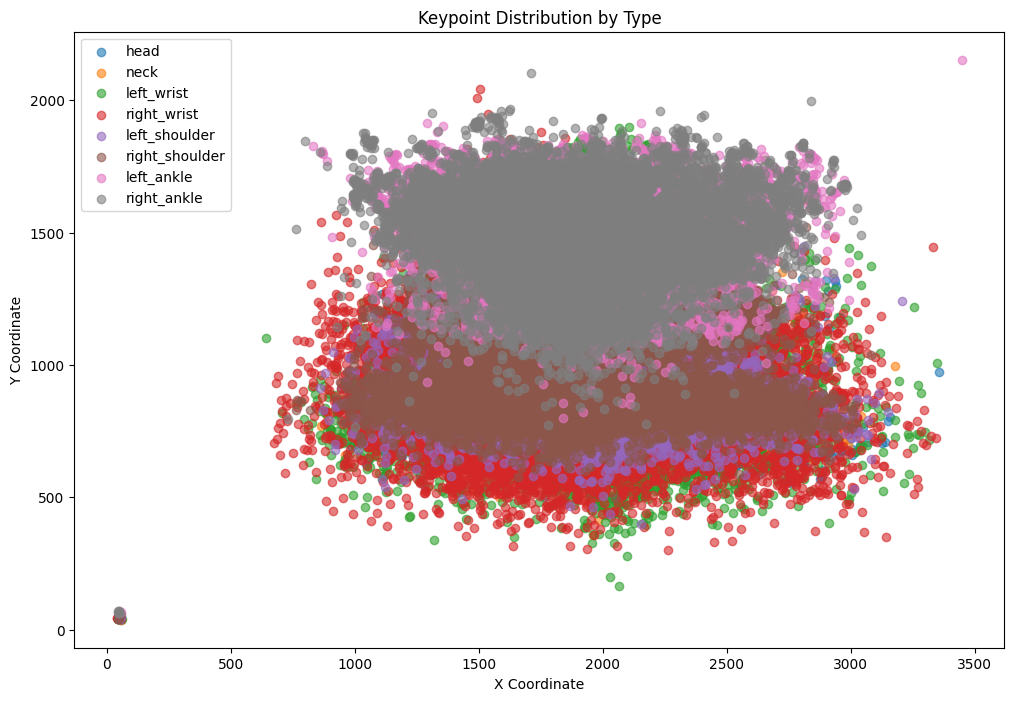

In [20]:
# 8개 키포인트 전체적인 상관관계 분석1

import matplotlib.pyplot as plt

# 키포인트별로 그룹화하여 시각화
plt.figure(figsize=(12, 8))
keypoints = df_interpolated['keypoint_name'].unique()

for keypoint in keypoints:
    subset = df_interpolated[df_interpolated['keypoint_name'] == keypoint]
    plt.scatter(subset['x'], subset['y'], label=keypoint, alpha=0.6)

plt.title('Keypoint Distribution by Type')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()


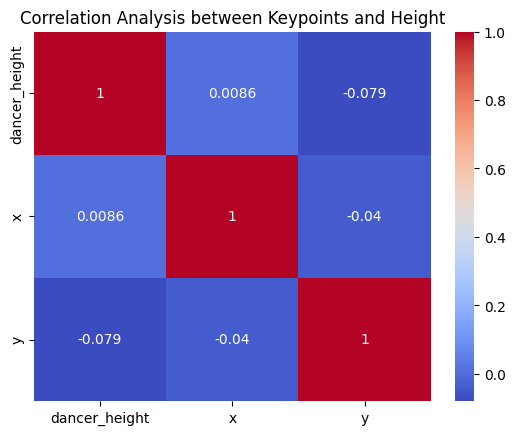

In [63]:
import seaborn as sns

# 상관관계 분석
correlation = df[['dancer_height', 'x', 'y']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis between Keypoints and Height')
plt.show() # --> 댄서 키랑은 딱히 상관 없음

---

#### 📊 <font color="skyblue">**Analysis 2**</font>

- 댄서 키와 \( x, y \) 좌표 간의 상관관계가 매우 낮게 나타남
  - 키: 신체 크기를 나타내는 **절대적 크기**.
  - \( x, y \): 프레임 내 **상대적 위치**를 나타내는 데이터
- 좌표 데이터가 **프레임 중심의 상대적 위치**를 표현하기 때문에, 신체 크기(키)와 직접적인 상관성이 낮음.


#### <font color="skyblue">**🛠️ 활용 방안**</font>

1️⃣ **데이터 기반 가설 제안**
  - **키 대비 움직임의 크기(속도 또는 가속도)** 를 계산하면, **상관성이 높아질 가능성**이 있음.

2️⃣ **모델에서의 활용 방안**

A. **키를 기준으로 데이터 정규화 (Normalization)**
   - \( x \)와 \( y \) 좌표 데이터를 **댄서의 키**로 나누어, **상대적 움직임 데이터**로 변환:

$$
x_{\text{normalized}} = \frac{x}{\text{height}}, \quad y_{\text{normalized}} = \frac{y}{\text{height}}
$$
   - 이를 통해, 다양한 키의 데이터를 **동일한 스케일**에서 비교 가능.

B. **속도와 가속도의 상대적 크기 분석**
   - **속도(velocity)** 와 **가속도(acceleration)** 데이터를 키로 정규화:
$$
\text{Velocity}_{\text{normalized}} = \frac{\text{Velocity}}{\text{height}}, \quad \text{Acceleration}_{\text{normalized}} = \frac{\text{Acceleration}}{\text{height}}
$$

   - 이를 기반으로, 돌발 행동 탐지 모델의 **일관성과 정확도** 개선
   - 최종적으로 다양한 신체 크기를 가진 보행자 데이터를 처리할 수 있는 **일반화 성능** 확보.

C. **모델 학습에 적용**
   - 정규화된 데이터를 **추가 특징(feature)**  모델 학습에 포함.
   - 예: **정규화된 속도와 가속도**를 모델에 적용하여 돌발 행동 패턴을 더욱 정밀하게 탐지.

---





### ✅ 3. 히트맵 상관관계 기반 키포인트 선택

#### 📌 **목표**  
- 키포인트 간의 움직임 상관관계를 확인하여 돌발 행동 예측에 중요한 키포인트를 선택.

#### 🛠️ **진행 단계**

**3.1 특정 키포인트의 상관관계**
- 상관계수가 높은 키포인트를 확인하여 돌발 행동과의 연관성을 분석.  
- <예시>  
- `left_knee`와 `right_knee` 간 상관관계가 높다면 대칭적인 다리 움직임이 돌발 행동의 중요한 지표일 수 있음.  
- `right_wrist`와 `right_shoulder` 간 상관관계가 높다면 손과 어깨의 연관성을 기반으로 상체 움직임 분석 가능.

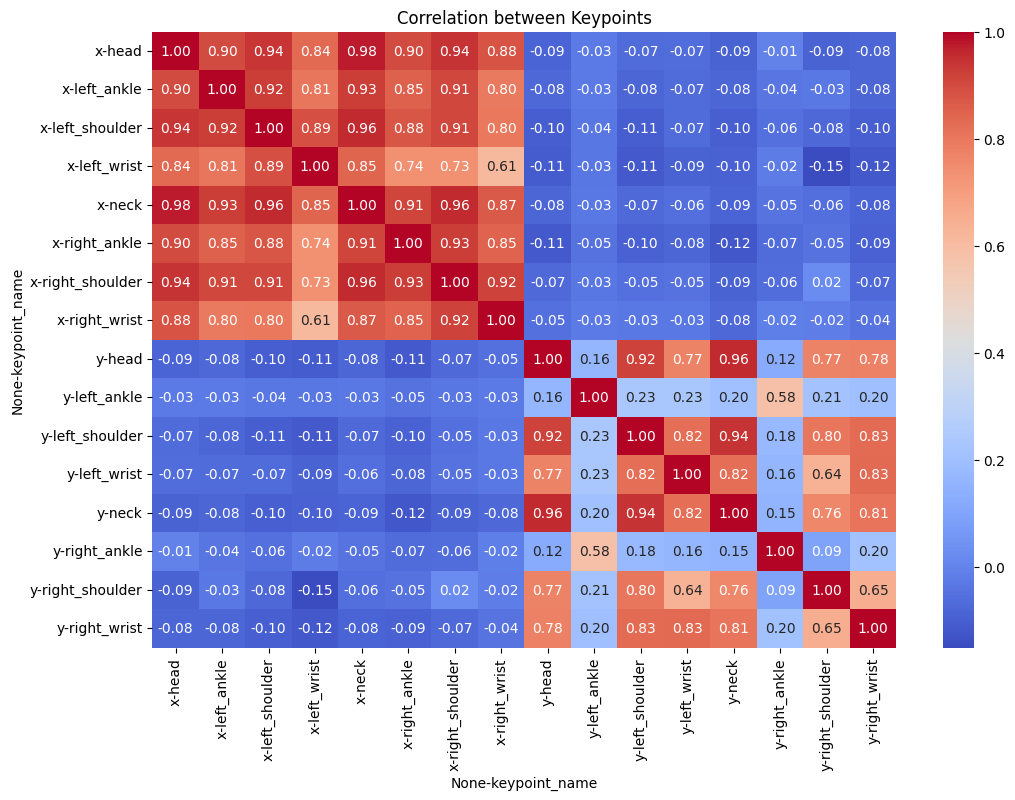

In [21]:
# 중복 제거
df_interpolated = df_interpolated.drop_duplicates(subset=['file_name', 'keypoint_name'])

# 피벗 테이블 생성
correlation_matrix = df_interpolated.pivot(index='file_name', columns='keypoint_name', values=['x', 'y']).corr()

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation between Keypoints')
plt.show()


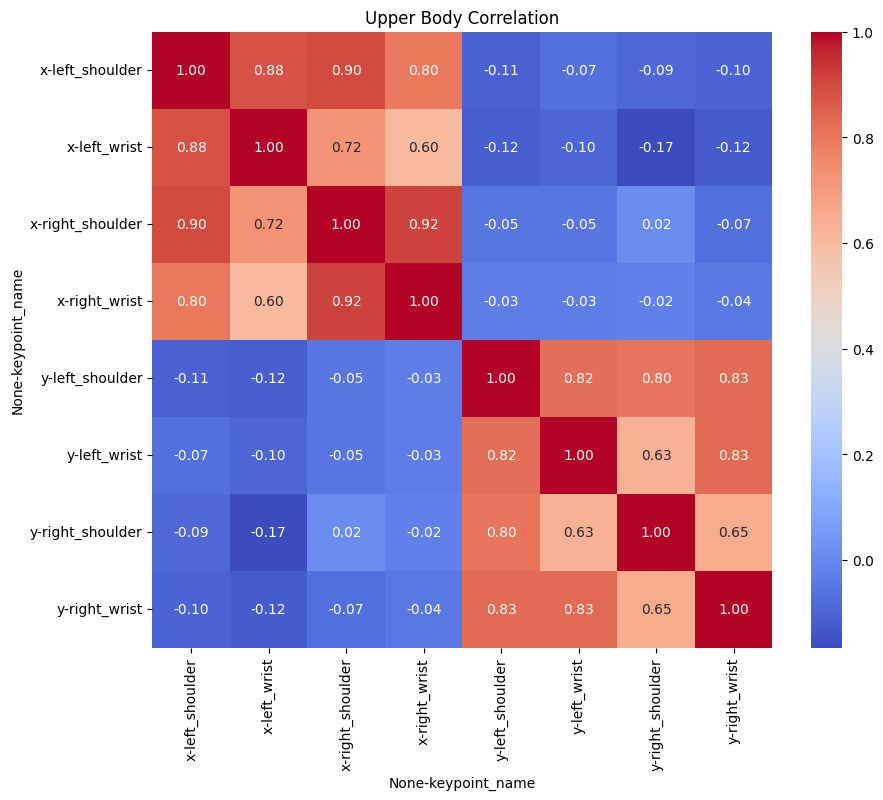

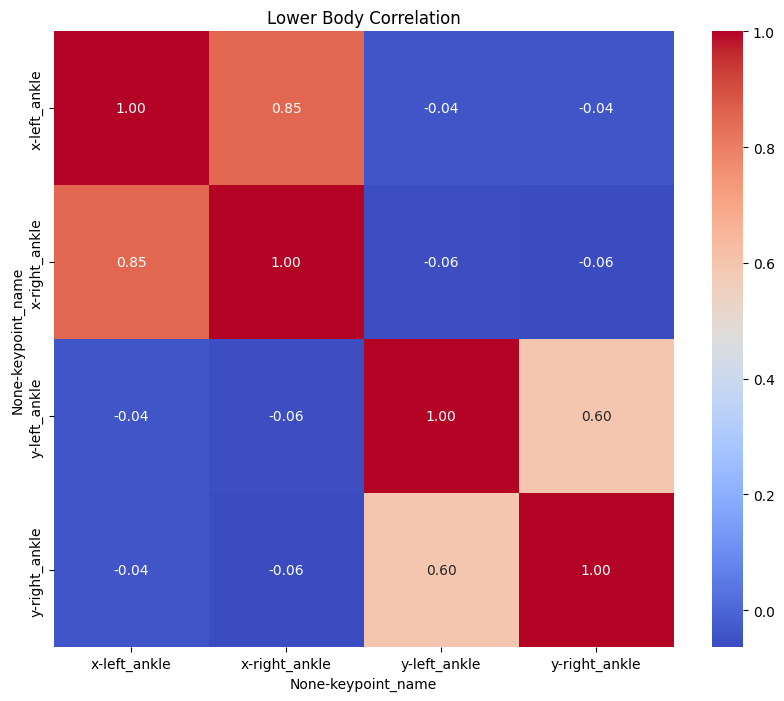

In [22]:
# 상관관계 그룹화 추가 진행

import seaborn as sns
import matplotlib.pyplot as plt

# 상체와 하체 그룹 정의
upper_body = ['left_shoulder', 'right_shoulder', 'left_wrist', 'right_wrist']
lower_body = ['left_knee', 'right_knee', 'left_ankle', 'right_ankle']

# 상관관계 계산
upper_corr = (
    df_filtered[df_filtered['keypoint_name'].isin(upper_body)]
    .pivot_table(index='file_name', columns='keypoint_name', values=['x', 'y'], aggfunc='mean')  # 중복 데이터를 평균으로 처리
    .corr()
)

lower_corr = (
    df_filtered[df_filtered['keypoint_name'].isin(lower_body)]
    .pivot_table(index='file_name', columns='keypoint_name', values=['x', 'y'], aggfunc='mean')  # 중복 데이터를 평균으로 처리
    .corr()
)


# 상체 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(upper_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Upper Body Correlation")
plt.show()

# 하체 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(lower_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Lower Body Correlation")
plt.show()


---

#### 📊 <font color="skyblue">**Analysis 3**</font>

- **(a) 상체(upper_body)** (어깨, 손목) : left_shoulder, right_shoulder, left_wrist, right_wrist
- **(b) 하체(lower_body)** (무릎, 발목) : left_knee, right_knee, left_ankle, right_ankle
- **(c) 혼합(mixed_body)** (상체-하체 협응): shoulder ↔ knee, wrist ↔ ankle


##### **1. 히트맵 기반 상관관계 분석**

**(a) 상체 그룹(upper_body)**
- **`left_shoulder` ↔ `right_shoulder` **<font color="orange">**(상관계수 ≈ 0.92~0.94)**</font>   
    - 양쪽 어깨는 상체의 중심 움직임을 반영하며 강한 대칭적 상관관계를 보임
    - 무단횡단할 때 손을 흔들거나 갑작스럽게 팔을 움직이는 행동을 감지할 수 있음

- **`left_wrist` ↔ `right_wrist`**  <font color="orange">**(상관계수 ≈ 0.83~0.85)**</font>  
   - 양쪽 손목은 비슷한 움직임 패턴을 보이며, 손의 흔들림 분석에 유효함

- **`shoulder ↔ wrist 관계`** <font color="orange">**(상관계수 ≈ 0.64~0.78)**</font>   
   - 어깨와 손목의 연관성은 상체의 유기적인 움직임 분석에 활용 가능

<br>

**(b) 하체 그룹(lower_body)**

- **`left_knee` ↔ `right_knee`, `left_ankle` ↔ `right_ankle`** <font color="orange">**(상관계수 ≈ 0.77~0.92)**</font> 
    - 무릎과 발목의 대칭적 움직임은 방향 전환 및 속도 분석에 중요

- **`ankle ↔ knee 관계`** <font color="orange">**(상관계수 ≈ 0.58~0.77)**</font>  
    - 발목과 무릎의 상관관계는 하체 움직임 패턴과 가속도 분석에 유효

<br>

**(c) 혼합 그룹 (mixed_body)**
- 상체(`shoulders`, `wrists`)와 하체(`knees`, `ankles`) 간 상관관계는 비교적 낮음 <font color="orange">**(상관계수 ≈ 0.1~0.3)**</font>  
   - 이는 상체와 하체의 움직임이 독립적으로 동작할 가능성을 시사
   - 단, <font color="orange">돌발 행동 시 상체와 하체가 동시에 강한 움직임</font> 을 보일 가능성을 추가 분석해야 함

<br>

##### **2. 분포 시각화 기반 추가 확인**
- **상체 (어깨와 손목)**
    - 위치 분포가 하체에 비해 더 분산되어 있으며 이는 움직임의 다양성과 유연성을 의미함  

- **하체 (무릎과 발목)**
    - 위치 분포가 상대적으로 밀집되어 있으며 이는 대칭적 움직임과 방향 전환을 명확히 포착할 수 있음을 의미함

<br>

<div style="border-top: 2px solid skyblue;"></div>

#### 💡 <font color="skyblue">**INSIGHT**</font>
##### 🚀 <font color="skyblue">**키포인트 기반 행동 분석: 상체와 하체의 역할**</font>
- 1️⃣ 어깨(left_shoulder, right_shoulder)와 손목(left_wrist, right_wrist)은 상체 움직임의 핵심으로 무단횡단할 때 <font color="skyblue">손을 흔들거나 갑작스럽게 팔을 움직이는 행동을 감지</font>  할 수 있음
- 2️⃣ 무릎(left_knee, right_knee)과 발목(left_ankle, right_ankle)은 대칭적인 움직임이나 방향 전환을 볼 때 중요함 따라서 <font color="skyblue">도로에 빠르게 뛰어들거나 이동 속도가 급격히 변하는 상황을 예측</font>할 수 있음
- 3️⃣ 결론적으로 어깨와 무릎, 손목과 발목처럼 상하체의 연결 관계를 통해 <font color="skyblue">**상체-하체가 동시에 협응해서 나타나는 행동(예: 갑자기 뛰어드는 경우)을 탐지**</font>할 수 있음

<br>

---


### ✅ 4. 키포인트 선택 및 속도 변화 패턴 분석

#### 📌 **분석 목표**  
- 시간에 따른 키포인트의 속도 변화 및 이상 행동 패턴을 분석하여 돌발 행동을 탐지.

#### 🛠️ **진행 단계**
**4.1 속도 계산**  
- 시간 순으로 데이터 정렬.  
- 유클리드 거리 기반 속도 계산:  
 $$ \text{속도 (Velocity)} = \frac{\Delta 거리}{\Delta 시간} $$

**4.2 거리 계산**  
- 거리 = $$ \sqrt{\Delta x^2 + \Delta y^2} $$  

**4.3 속도 시각화**
- 특정 키포인트의 시간에 따른 속도 변화를 시각화.  
- 급격한 속도 변화가 발생하는 키포인트를 탐지하여 돌발 행동의 가능성을 분석.

<br>

#### 💾 **JSON 데이터 세부 정보**
- 메타 데이터 세부 내용 
    - 키포인트 (x, y 좌표) : 무용수 움직임에서 추출된 22개의 키포인트(head, left_shoulder, left_wrist, right_ankle 등 포함)
    - 어노테이션 : 각 움직임에 대한 키포인트 위치가 60 프레임/초(FPS)로 기록
    - 해상도 : 4K (3840x2160 픽셀)로 촬영.
    
    <br>
    
    - 좌표 및 속도 단위
        - 모든 x, y 좌표는 픽셀(pixels) 단위.
        - 속도는 픽셀/프레임(pixels/frame) 단위로 측정.
---


In [23]:
import numpy as np

# 데이터 정렬
df_sorted = df_filtered.sort_values(by=['file_name'])

# Δx, Δy, Δ시간 계산
df_sorted['dx'] = df_sorted['x'].diff()
df_sorted['dy'] = df_sorted['y'].diff()
df_sorted['dt'] = 1  # assuming 1 frame per time step

# 유클리드 거리 및 속도 계산
df_sorted['distance'] = np.sqrt(df_sorted['dx']**2 + df_sorted['dy']**2)
df_sorted['velocity'] = df_sorted['distance'] / df_sorted['dt']

# 가속도 계산
df_sorted['acceleration'] = df_sorted['velocity'].diff() / df_sorted['dt']

# 결과 확인
print(df_sorted[['file_name', 'keypoint_name', 'velocity', 'acceleration']].head())


                               file_name  keypoint_name    velocity  \
90920  MC01_A01_B001_CA1_M0001_1005.json           head         NaN   
90935  MC01_A01_B001_CA1_M0001_1005.json    right_ankle  697.938596   
90932  MC01_A01_B001_CA1_M0001_1005.json  left_shoulder  513.262313   
90931  MC01_A01_B001_CA1_M0001_1005.json    right_wrist   60.468591   
90930  MC01_A01_B001_CA1_M0001_1005.json     left_wrist   60.468591   

       acceleration  
90920           NaN  
90935           NaN  
90932 -1.846763e+02  
90931 -4.527937e+02  
90930  3.765876e-13  


---

#### 📊 <font color="skyblue">**Analysis 4**</font>

1. **속도 (velocity)**
- 각 키포인트의 이동 속도를 의미함. 예를 들어 right_ankle의 속도는 약 697.94로 다른 키포인트보다 빠르게 움직였음을 알 수 있음
- NaN : 첫 행에는 속도를 계산할 이전 데이터가 없기 때문에 속도 값이 NaN으로 표시됨

<br>

2. **가속도 (acceleration)**
- 각 키포인트의 속도 변화율(가속도)을 의미함. 예를 들어 left_shoulder의 가속도는 약 -184.68(음수)로 속도가 줄어들고 있음을 알 수 있음
- 가속도 역시 속도의 Nan값과 마찬가지로 계산할 이전 속도 데이터가 없기 때문에 NaN으로 표시됨

<br>

3. **속도와 가속도 값이 작거나 거의 0인 경우**
- left_wrist와 right_wrist의 가속도가 거의 0에 가까운 값(3.765876e-13)으로 나타남
- 이는 움직임 변화가 거의 없거나 데이터 정밀도에 따른 오차범위로 추측함

---

In [24]:
#속도/가속도 기준으로 데이터를 구간화하고, 그룹별로 분석

import pandas as pd
import numpy as np

# 속도/가속도 구간 설정 함수
def classify_motion(row):
    if row['velocity'] <= 500:
        return 'Normal'
    elif 500 < row['velocity'] <= 1000:
        return 'High Speed'
    else:
        return 'Irregular'

# 각 키포인트별 데이터 분리
keypoints = ['head', 'neck', 'left_shoulder', 'right_shoulder', 
             'left_wrist', 'right_wrist', 'left_ankle', 'right_ankle']

grouped_data = {}
for keypoint in keypoints:
    keypoint_data = df_sorted[df_sorted['keypoint_name'] == keypoint].copy()
    # 속도/가속도 구간 분류
    keypoint_data['motion_category'] = keypoint_data.apply(classify_motion, axis=1)
    grouped_data[keypoint] = keypoint_data

# 상체 그룹, 하체 그룹, 혼합 그룹 정의
upper_body = ['left_shoulder', 'right_shoulder', 'left_wrist', 'right_wrist']
lower_body = ['left_ankle', 'right_ankle']
mixed_body = ['left_shoulder', 'left_ankle', 'right_shoulder', 'right_ankle']

# 상체 그룹 분석
upper_body_data = pd.concat([grouped_data[kp] for kp in upper_body])
upper_summary = upper_body_data['motion_category'].value_counts()

# 하체 그룹 분석
lower_body_data = pd.concat([grouped_data[kp] for kp in lower_body])
lower_summary = lower_body_data['motion_category'].value_counts()

# 혼합 그룹 분석
mixed_body_data = pd.concat([grouped_data[kp] for kp in mixed_body])
mixed_summary = mixed_body_data['motion_category'].value_counts()

# 결과 출력
print("Upper Body Motion Summary:")
print(upper_summary)
print("\nLower Body Motion Summary:")
print(lower_summary)
print("\nMixed Body Motion Summary:")
print(mixed_summary)

Upper Body Motion Summary:
motion_category
Normal        117681
High Speed     22127
Irregular        576
Name: count, dtype: int64

Lower Body Motion Summary:
motion_category
Normal        40874
High Speed    28558
Irregular       760
Name: count, dtype: int64

Mixed Body Motion Summary:
motion_category
Normal        99103
High Speed    40285
Irregular       996
Name: count, dtype: int64


---

#### 📊 <font color="skyblue">**Analysis 5**</font>

1. 상체 그룹 (Upper Body)
- **Normal (정상)**: 117,681개 → 대부분 안정적 움직임.  
- **High Speed (고속)**: 22,127개 (15%) → 팔, 어깨의 급격한 흔들림 감지 가능.  
- **Irregular (비정형)**: 576개 (0.4%) → 돌발 행동의 유의미한 신호.  

2. 하체 그룹 (Lower Body)
- **Normal (정상)**: 40,874개 → 대부분 정상 속도.  
- **High Speed (고속)**: 28,558개 (40%) → 방향 전환, 뛰어들기 등 이동과 관련.  
- **Irregular (비정형)**: 760개 (1.2%) → 돌발 행동의 주요 신호.  


3. 혼합 그룹 (Mixed Body)
- **Normal (정상)**: 99,103개 → 대부분 정상 움직임.  
- **High Speed (고속)**: 40,285개 (29%) → 상체-하체 협응 시 고속 패턴 증가.  
- **Irregular (비정형)**: 996개 (2.4%) → 돌발 행동 가능성이 가장 높은 그룹.  

<br>

<div style="border-top: 2px solid skyblue;"></div>

#### 💡 <font color="skyblue">**INSIGHT**</font>
##### 🚀 <font color="skyblue">**돌발 행동 탐지를 위한 데이터 라벨링 전략**</font>

1️⃣ **상체 vs. 하체 움직임 차이**  
  - 하체는 고속 비율이 높아 이동 관련 행동에 중요한 역할.  
  - 상체의 비정형 움직임은 돌발 행동 예측에 유의미.  

2️⃣ **혼합 그룹의 중요성**  
- 상체-하체 협응에서 비정형 비율이 가장 높아 돌발 행동 탐지 가능성 큼.  

3️⃣ **모델 학습 데이터 라벨링**  
- **Normal (0)**: 정상  
- **High Speed (1)**: 고속  
- **Irregular (2)**: 비정형

- <font color="orange">*속도 분포 선 분석을 통해 라벨링을 위한 임계값(threshold)을 지정하는 추가 단계를 진행함*</font> 

<br>

<div style="border-top: 2px solid skyblue;"></div>

#### <font color="skyblue">**🛠️ 활용 방안**</font>

1️⃣ **데이터 기반 가설 제안**
- 혼합 그룹(shoulder ↔ knee, wrist ↔ ankle)의 고속/비정형 움직임 데이터는 돌발 행동 탐지의 중요한 특징을 제공.
- 상체와 하체의 협응 데이터를 활용해 **특징 벡터(feature vector)**를 설계하거나, 혼합 그룹 데이터에 가중치를 부여하여 돌발 행동 예측 성능을 향상시킬 수 있음.
- 예를 들어, 어깨와 손목 움직임이 하체의 무릎, 발목 움직임과 동시에 비정형 패턴을 보일 경우, 돌발 행동 가능성이 높은 신호로 간주할 수 있음.

2️⃣ **모델 학습 적용 시뮬레이션**
- 혼합 그룹에서 고속/비정형 데이터를 필터링하여 YOLOv8 및 Mask R-CNN 기반의 보행자 객체 탐지 모델 학습.
- 학습 데이터 구성 전략:
  - 상체 데이터: 안정적 움직임을 기준으로 정상 상태를 학습.
  - 하체 데이터: 고속/비정형 데이터를 학습하여 돌발 행동에 민감한 모델 설계.
  - 혼합 데이터: 상체-하체 협응 데이터를 사용해 복합적인 행동 패턴 탐지.
- 학습된 모델을 통해 정상/고속/비정형 행동을 구분하고, **정확도(precision)**와 재현율(recall) 성능을 평가.

3️⃣ **일반 보행자 데이터와 비교**
- 학습된 모델에 일반적인 보행자 데이터(도로 위 실제 데이터)를 추가하여, 탈춤 데이터의 일반화 성능을 평가.
  - 예: 무단횡단, 방향 전환, 갑작스러운 뛰어들기 등의 행동이 모델에서 얼마나 효과적으로 탐지되는지 테스트.
- 탈춤 데이터 기반 돌발 행동 탐지 모델이 현실 데이터와 얼마나 일치하는지 분석하여 현장 적용 가능성을 확보.


---

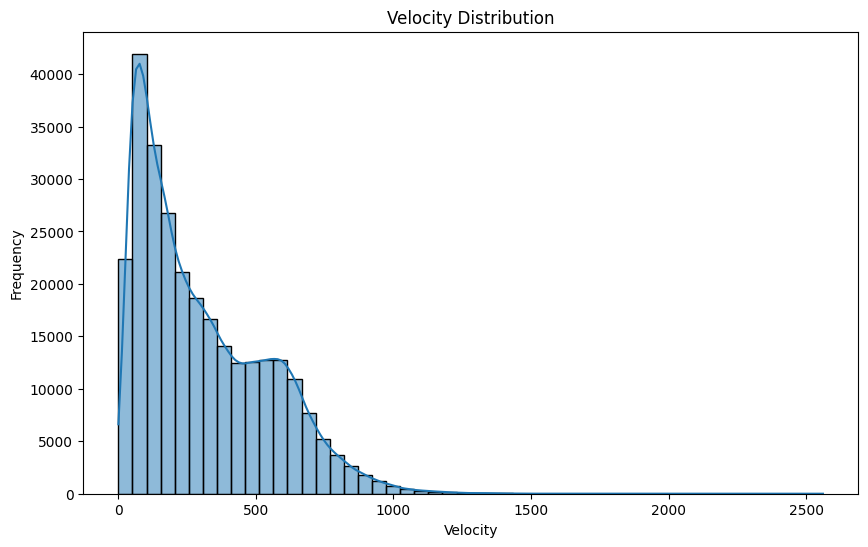

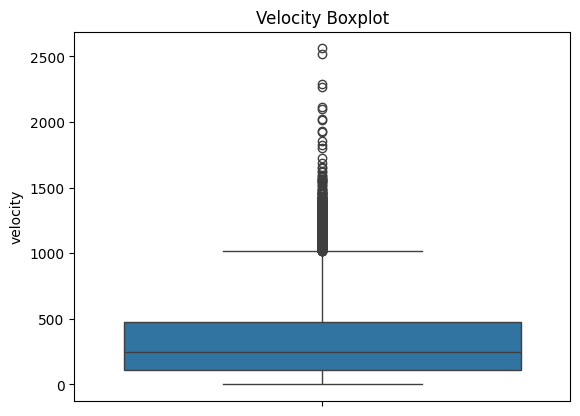

In [25]:
#1. 먼저 속도값 분포 시각화 진행

import seaborn as sns
import matplotlib.pyplot as plt

# 속도 히스토그램
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted['velocity'], bins=50, kde=True)
plt.title("Velocity Distribution")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
plt.show()

# 속도 박스 플롯
sns.boxplot(df_sorted['velocity'])
plt.title("Velocity Boxplot")
plt.show()


---

#### 📊 <font color="skyblue">**Analysis 6**</font>

**1. 속도 분포 히스토그램**

- 오른쪽 꼬리가 긴 형태로 대부분의 데이터가 낮은 속도에 집중되어 있음
- 낮은 속도(약 0~500) 구간에서 높은 빈도를 보이며 이 구간이 **정상 움직임(Normal)** 으로 간주될 가능성이 높음.
- 1000 이상의 속도는 상대적으로 드문 이상값이나 비정형 움직임(Irregular)으로 볼 수 있음.

**2.속도 박스플롯**

- **중앙값(Median)** 은 약 250~300 수준으로 보입니다.
- 박스플롯의 **상한선(whisker)** 은 약 1000 부근에 위치하며, 그 이상은 **이상값(outliers)** 로 간주됩니다.
- 이상값(outliers)은 속도가 1000 이상인 데이터로, 이를 기준으로 비정형 행동을 구분할 수 있습니다.


<br>

<div style="border-top: 2px solid skyblue;"></div>

#### 💡 <font color="skyblue">**INSIGHT**</font>
##### 🚀 <font color="skyblue">**모델 학습 라벨링 세부 기준 (feat.pixels/frame)**</font>

- 속도 박스플롯으로 확인한 결과 1000 이상을 이상치로 분석하고 있음
- 히스토그램과 박스플롯의 분석 결과를 바탕으로 내린 모델 학습 데이터 라벨링의 세부 기준은 아래와 같음

    - **Normal (0)**: 0~500 *pixels/frame*  
    - **High Speed (1)**: 500~1000 *pixels/frame*  
    - **Irregular (2)**: 1000 이상 *pixels/frame*
 
<br>

---

In [45]:
Q1 = df_sorted['velocity'].quantile(0.25)  # 1사분위수
Q3 = df_sorted['velocity'].quantile(0.75)  # 3사분위수
IQR = Q3 - Q1


normal_min = max(0, Q1 - 1.5 * IQR)  # 정상 속도의 최솟값은 0 이상이어야 함
normal_max = Q3 + 1.5 * IQR          # 정상 속도의 최댓값


# 가속도 기준
accel_threshold = df_sorted['acceleration'].quantile(0.95)

# normal_min = Q1 - 1.5 * IQR  # 정상 속도의 최솟값
# normal_max = Q3 + 1.5 * IQR  --> # Normal Range: -435.2411536245031 ~ 1019.9932780499717 이렇게 나오는데 속도는 음수가 없음 -> 최솟값 강제 추가 진행


In [46]:
print(f"Normal Range: {normal_min} ~ {normal_max}") 

Normal Range: 0 ~ 1019.9932780499717


In [47]:
# 속도 기반 라벨링
df_sorted['motion_category'] = 0  # 기본 Normal
df_sorted.loc[df_sorted['velocity'] > normal_max, 'motion_category'] = 1  # High Speed
df_sorted.loc[df_sorted['velocity'] < normal_min, 'motion_category'] = 2  # Irregular

# 가속도 기준으로 Irregular 보완
df_sorted.loc[df_sorted['acceleration'] > accel_threshold, 'motion_category'] = 2


In [62]:
print(df_sorted[['velocity', 'acceleration', 'motion_category']][0:10])

         velocity  acceleration  motion_category
90920         NaN           NaN                0
90935  697.938596           NaN                0
90932  513.262313 -1.846763e+02                0
90931   60.468591 -4.527937e+02                0
90930   60.468591  3.765876e-13                0
90929   33.431814 -2.703678e+01                0
90928   33.431814  7.105427e-15                0
90934  443.934005  4.105022e+02                0
90927  336.297567 -1.076364e+02                0
90926  198.590080 -1.377075e+02                0


In [49]:
df_sorted.tail(5)
# print(type(df_sorted)) #<class 'pandas.core.frame.DataFrame'>

,file_name,dancer_height,keypoint_name,x,y,dx,dy,dt,distance,velocity,acceleration,motion_category
257763,MC01_A10_B101_CA1_M0001_600.json,161,right_wrist,1502.651085,1047.935300,-268.673081,-28.669614,1,270.198392,270.198392,-182.260432,0
257765,MC01_A10_B101_CA1_M0001_600.json,161,right_shoulder,1594.724444,1119.609335,92.073359,71.674035,1,116.681921,116.681921,-153.516471,0
257766,MC01_A10_B101_CA1_M0001_600.json,161,left_ankle,1678.496107,1464.399167,83.771663,344.789832,1,354.820687,354.820687,238.138765,0
257761,MC01_A10_B101_CA1_M0001_600.json,161,neck,1641.472583,1135.269912,-37.023524,-329.129255,1,331.205085,331.205085,-23.615602,0
257764,MC01_A10_B101_CA1_M0001_600.json,161,left_shoulder,1670.949110,1125.645043,29.476528,-9.624868,1,31.008124,31.008124,-300.196960,0


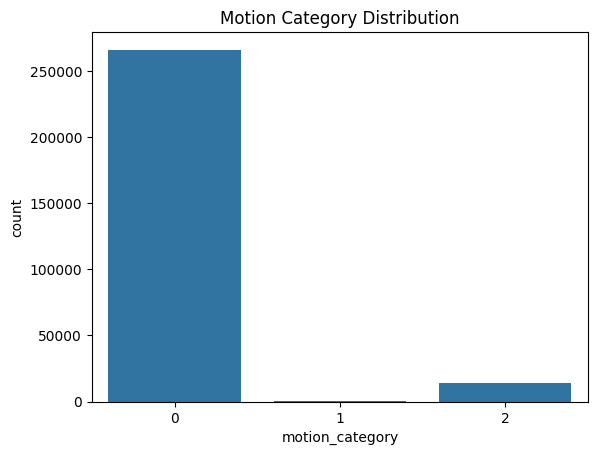

In [52]:
# 카테고리 분포 확인
sns.countplot(data=df_sorted, x='motion_category')
plt.title("Motion Category Distribution")
plt.show()


In [54]:
# 상체, 하체, 혼합 그룹 정의
upper_body = ['left_shoulder', 'right_shoulder', 'left_wrist', 'right_wrist']
lower_body = ['left_knee', 'right_knee', 'left_ankle', 'right_ankle']

# 'group' 열 추가
df_sorted['group'] = 'mixed'  # 기본값을 'mixed'로 설정
df_sorted.loc[df_sorted['keypoint_name'].isin(upper_body), 'group'] = 'upper'
df_sorted.loc[df_sorted['keypoint_name'].isin(lower_body), 'group'] = 'lower'


In [55]:
# 그룹별 데이터 분리
upper_group = df_sorted[df_sorted['group'] == 'upper']
lower_group = df_sorted[df_sorted['group'] == 'lower']
mixed_group = df_sorted[df_sorted['group'] == 'mixed']

# 각 그룹의 motion_category 분포 확인
print("Upper Body:", upper_group['motion_category'].value_counts())
print("Lower Body:", lower_group['motion_category'].value_counts())
print("Mixed Body:", mixed_group['motion_category'].value_counts())


Upper Body: motion_category
0    136976
2      3118
1       290
Name: count, dtype: int64
Lower Body: motion_category
0    61031
2     8949
1      212
Name: count, dtype: int64
Mixed Body: motion_category
0    68071
2     1972
1      149
Name: count, dtype: int64


In [57]:
df_sorted.head()

,file_name,dancer_height,keypoint_name,x,y,dx,dy,dt,distance,velocity,acceleration,motion_category,group
90920,MC01_A01_B001_CA1_M0001_1005.json,182,head,1881.878291,759.756574,NaN,NaN,1,NaN,NaN,NaN,0,mixed
90935,MC01_A01_B001_CA1_M0001_1005.json,182,right_ankle,1873.146299,1457.640545,-8.731992,697.883971,1,697.938596,697.938596,NaN,0,lower
90932,MC01_A01_B001_CA1_M0001_1005.json,182,left_shoulder,2118.671322,1006.912617,245.525023,-450.727928,1,513.262313,513.262313,-1.846763e+02,0,upper
90931,MC01_A01_B001_CA1_M0001_1005.json,182,right_wrist,2080.898241,1054.131733,-37.773080,47.219116,1,60.468591,60.468591,-4.527937e+02,0,upper
90930,MC01_A01_B001_CA1_M0001_1005.json,182,left_wrist,2043.125161,1101.350849,-37.773080,47.219116,1,60.468591,60.468591,3.765876e-13,0,upper


In [58]:
group_motion_crosstab = pd.crosstab(df_sorted['group'], df_sorted['motion_category'])
print(group_motion_crosstab)


motion_category       0    1     2
group                             
lower             61031  212  8949
mixed             68071  149  1972
upper            136976  290  3118


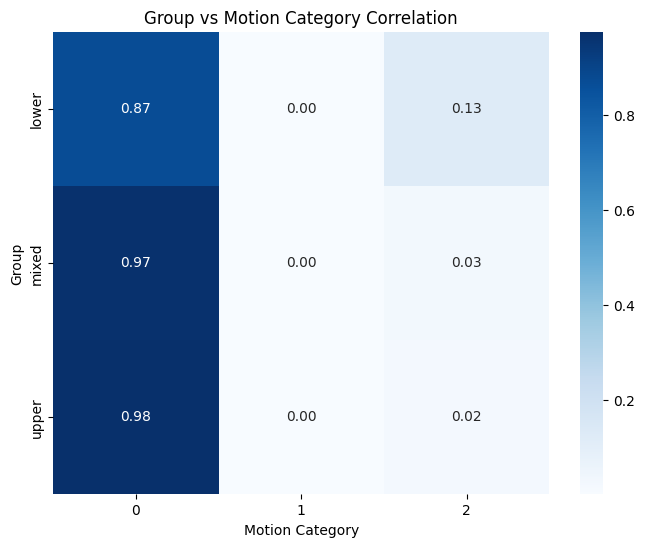

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# 교차표를 비율로 변환
group_motion_crosstab_ratio = group_motion_crosstab.div(group_motion_crosstab.sum(axis=1), axis=0)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(group_motion_crosstab_ratio, annot=True, cmap='Blues', fmt='.2f')
plt.title("Group vs Motion Category Correlation")
plt.xlabel("Motion Category")
plt.ylabel("Group")
plt.show()


---

#### 📊 <font color="skyblue">**Analysis 7**</font>

- **Normal (0)**
    - 상체(Upper): 98%의 움직임이 정상 범위에 속함.
    - 하체(Lower): 87%의 움직임이 정상 범위에 속하며, 다른 그룹에 비해 비율이 상대적으로 낮음.
    - 혼합(Mixed): 97%가 정상 범위에 속함.

- **High Speed (1)**
    - 모든 그룹에서 고속 움직임 비율은 극히 적음(0% 근처).

- **Irregular (2)**
    - 하체(Lower): 13%의 비정형 움직임이 관찰됨, 다른 그룹에 비해 비정형 비율이 가장 높음.
    - 상체(Upper): 2%만 비정형으로 나타남.
    - 혼합(Mixed): 비정형 비율은 3%로 상체보다 약간 높음.
